In [1]:
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
#from jupyterthemes import jtplot
#jtplot.style(theme='gruvboxd')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scipy.stats as stats
import pickle


In [2]:
# よく使ってる時刻を表示してくれるようになるprint関数のwrapper
def datePrint(*args, **kwargs):
    from datetime import datetime
    print(datetime.now().strftime('[%Y/%m/%d %H:%M:%S] '), end="")
    print(*args, **kwargs)

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.transform = transform
        self.data = data
        self.target = target
   
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        out_data = self.data[index]
        out_target = self.target[index]
        
        return out_data, out_target

In [4]:
def plot_result(y_true:np.array, y_est:np.array, lims=[0, 15]) -> None:
    fig,ax = plt.subplots(1,1,dpi=150,figsize=(5,5))
    heatmap, xedges, yedges = np.histogram2d(y_true, y_est, bins=100,range=(lims,lims))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    cset = ax.imshow(heatmap.T, extent=extent, origin='lower', norm=LogNorm(), cmap='rainbow')
    ax.plot(lims, lims, ls="--", color="black", alpha=0.5, label="ideal")
    plt.xlabel('target')
    plt.ylabel('output')
    ax.legend()
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(cset, cax=cax).ax.set_title("count")
    plt.show()
    

In [5]:
def cal_indicators(target_all, output_all):
    cor_list = []
    loss_list = []
    for n in range(len(target_all)):
        mse = 0
        cor = np.corrcoef(target_all[n], output_all[n])
        cor_list.append(cor[0, 1])
        for m in range(len(target_all[0])):
            mse += (target_all[n][m] - output_all[n][m]) **2
        mse = mse / len(output_all[n])
        loss_list.append(mse)

    return cor_list, loss_list

In [31]:
def visible_one(target_all, output_all):
    random = np.random.randint(0, len(target_all))
    print('random=',random)
    plt.figure(figsize=(15, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[random], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[random], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.xlabel('base position')
    plt.ylabel('accessibility')
    plt.title('one')
    plt.show()


In [27]:
def visible_minmax(target_all, output_all, cor_list, loss_list):
    plt.figure(figsize=(10, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmax(cor_list)], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmax(cor_list)], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.xlabel('base position')
    plt.ylabel('accessibility')
    plt.title('cor_max')
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmin(cor_list)], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmin(cor_list)], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.xlabel('base position')
    plt.ylabel('accessibility')
    plt.title('cor_min')
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmax(loss_list)], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmax(loss_list)], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.xlabel('base position')
    plt.ylabel('accessibility')
    plt.title('loss_max')
    plt.show()

    plt.figure(figsize=(10, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmin(loss_list)], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmin(loss_list)], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.xlabel('base position')
    plt.ylabel('accessibility')
    plt.title('loss_min')
    plt.show()

In [8]:
def show_base(data_all, cor_list, loss_list):
    cor_max = []
    cor_min = []
    loss_max = []
    loss_min = []
    for i in range(len(data_all[0])):
        if (data_all[np.argmax(cor_list)][i]==1):
            cor_max.append('A')
        elif (data_all[np.argmax(cor_list)][i]==2):
            cor_max.append('U')
        elif (data_all[np.argmax(cor_list)][i]==3):
            cor_max.append('G')
        elif (data_all[np.argmax(cor_list)][i]==4):
            cor_max.append('C')

        if (data_all[np.argmin(cor_list)][i]==1):
            cor_min.append('A')
        elif (data_all[np.argmin(cor_list)][i]==2):
            cor_min.append('U')
        elif (data_all[np.argmin(cor_list)][i]==3):
            cor_min.append('G')
        elif (data_all[np.argmin(cor_list)][i]==4):
            cor_min.append('C')

        if (data_all[np.argmax(loss_list)][i]==1):
            loss_max.append('A')
        elif (data_all[np.argmax(loss_list)][i]==2):
            loss_max.append('U')
        elif (data_all[np.argmax(loss_list)][i]==3):
            loss_max.append('G')
        elif (data_all[np.argmax(loss_list)][i]==4):
            loss_max.append('C')

        if (data_all[np.argmin(loss_list)][i]==1):
            loss_min.append('A')
        elif (data_all[np.argmin(loss_list)][i]==2):
            loss_min.append('U')
        elif (data_all[np.argmin(loss_list)][i]==3):
            loss_min.append('G')
        elif (data_all[np.argmin(loss_list)][i]==4):
            loss_min.append('C')
    print('cor_max', ''.join(cor_max))
    print('cor_min', ''.join(cor_min))
    print('loss_max', ''.join(loss_max))
    print('loss_min', ''.join(loss_min))

In [9]:

datePrint("loading input_test")
input_test = pickle.load(open("../data/acc_len5_random100/input_test.pkl","rb"))
datePrint("loading target_test")
target_test = pickle.load(open("../data/acc_len5_random100/target_test.pkl","rb"))

datePrint("loading input_train")
input_train = pickle.load(open("../data/acc_len5_random100/input_train.pkl","rb"))
datePrint("loading target_train")
target_train = pickle.load(open("../data/acc_len5_random100/target_train.pkl","rb"))

[2021/01/14 18:19:18] loading input_test
[2021/01/14 18:19:18] loading target_test
[2021/01/14 18:19:18] loading input_train
[2021/01/14 18:19:19] loading target_train


In [10]:
print(input_test.shape)
print(target_test.shape)
print(input_train.shape)
print(target_train.shape)

torch.Size([500000, 100])
torch.Size([500000, 96])
torch.Size([500000, 100])
torch.Size([500000, 96])


nyaa 0.0005


1.3064303206314434


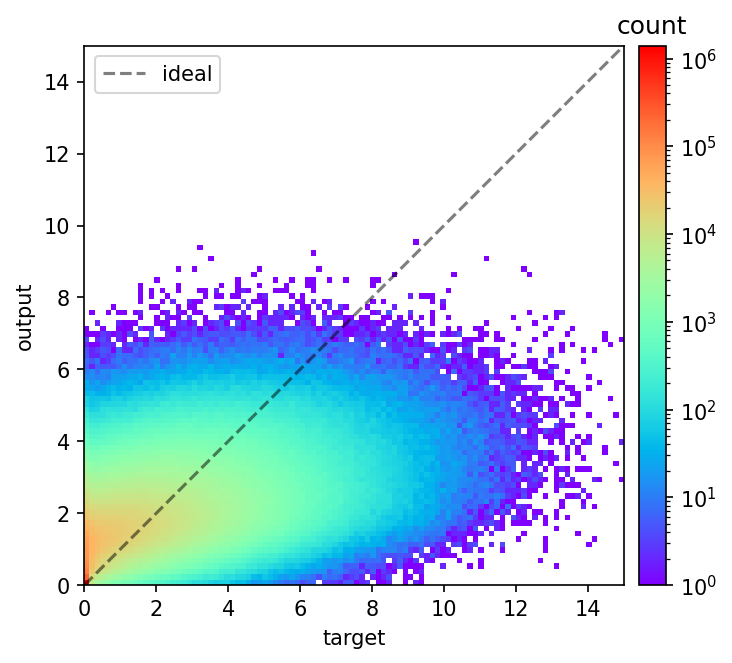

1.45905287347386


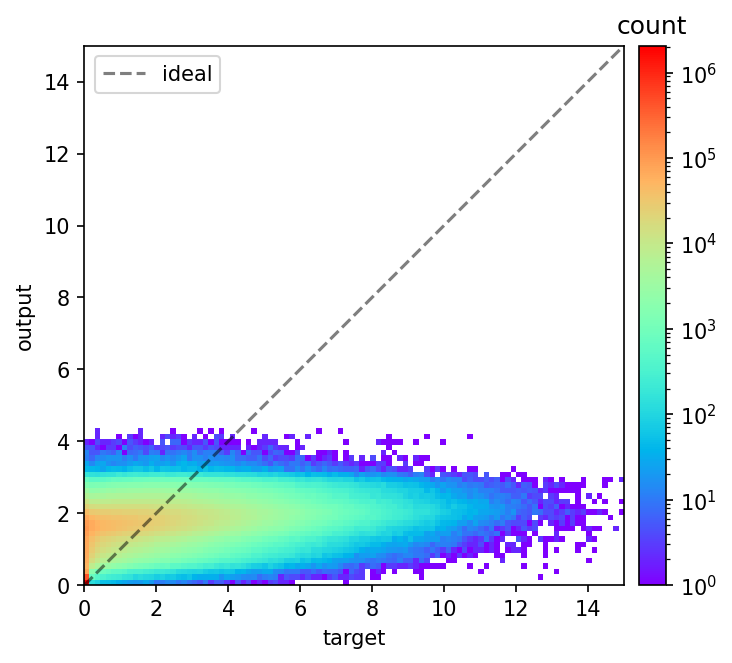

1.483950791188104


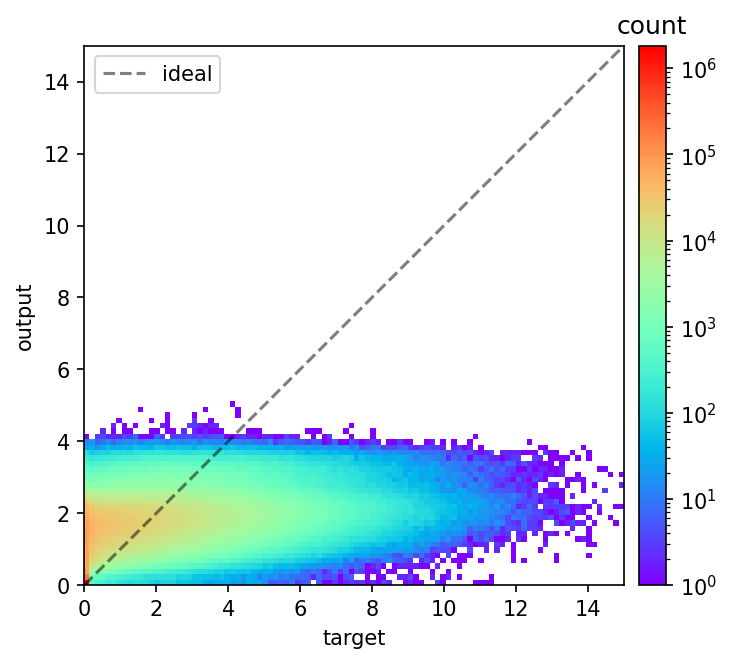

1.106518895215738


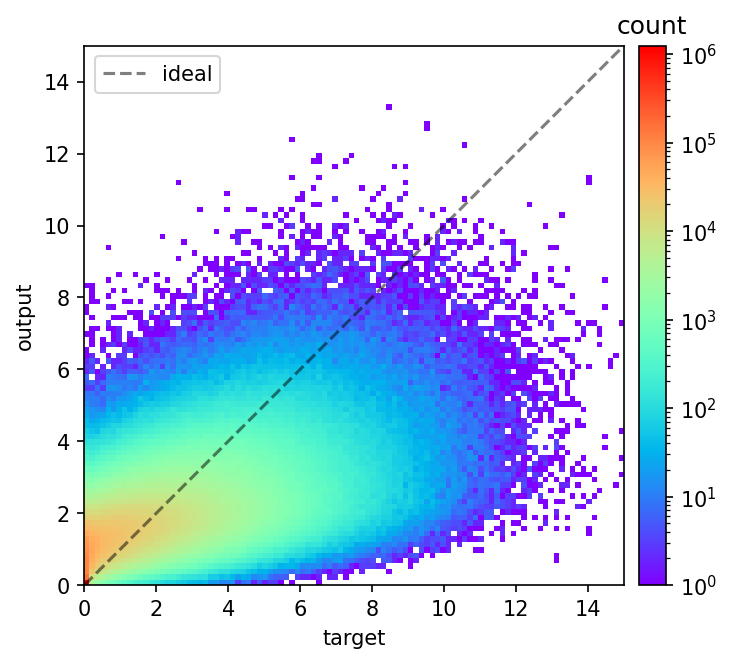

0.836114213204277


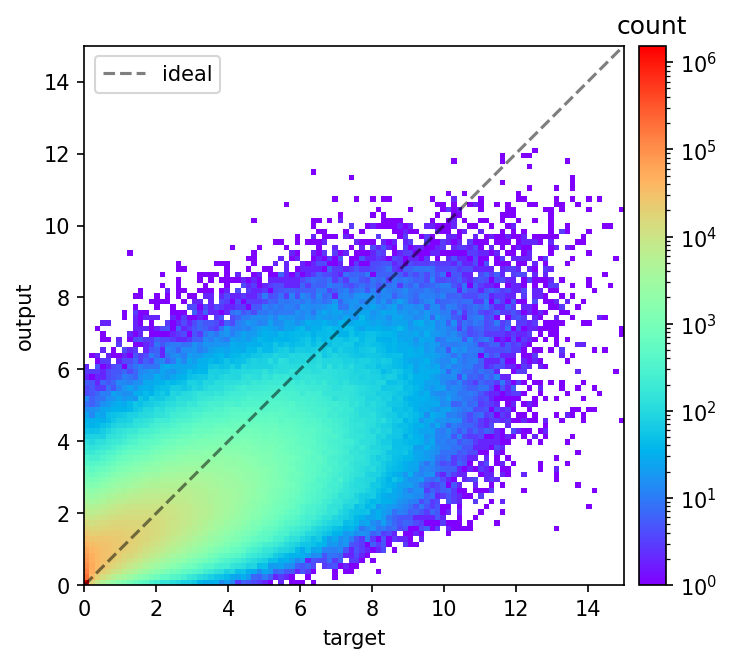

0.5676631246593924


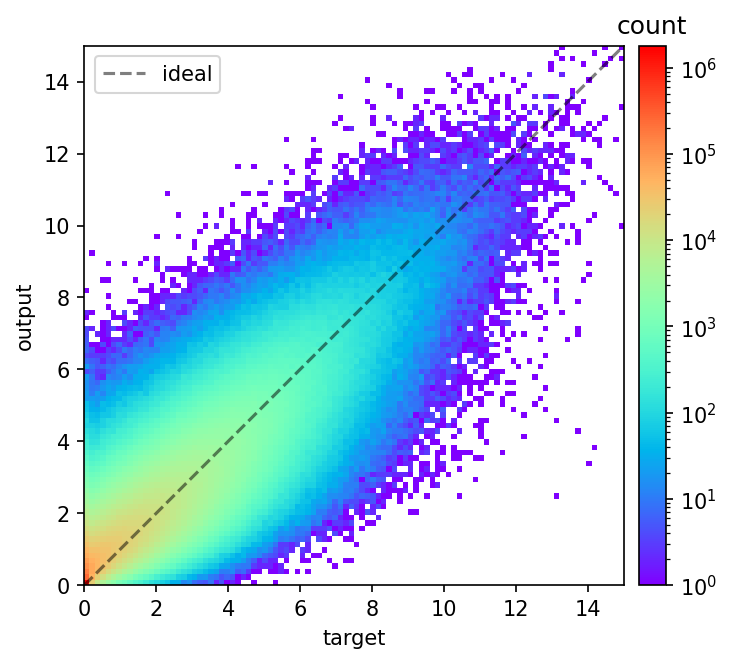

0.3963674033824557


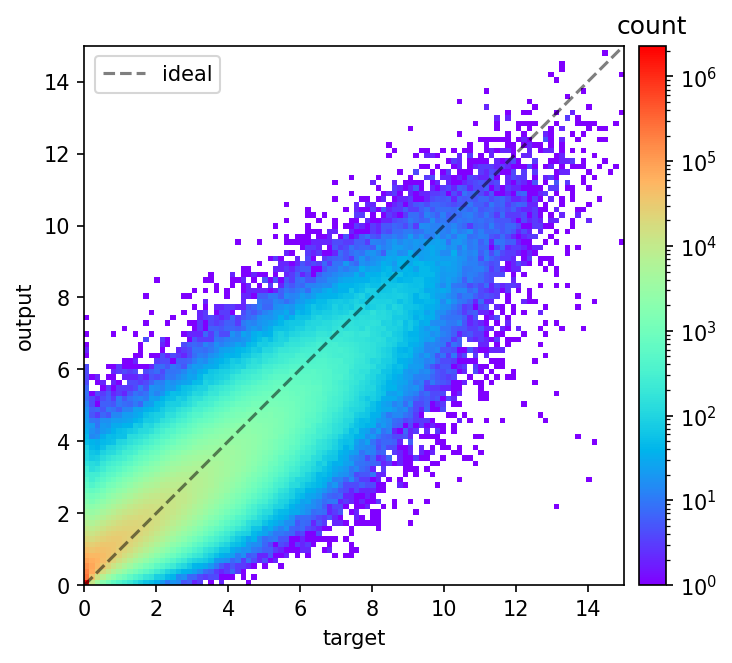

0.4046305314478627


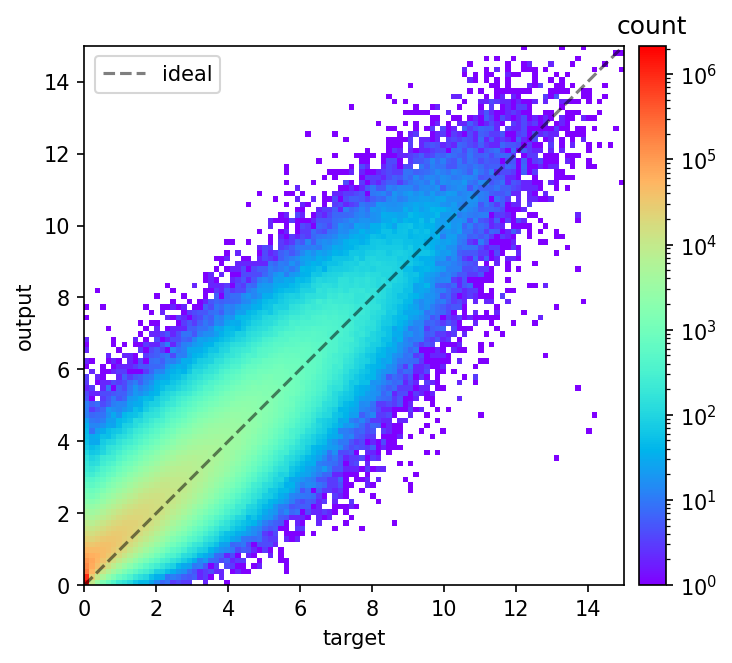

0.2474792437700606


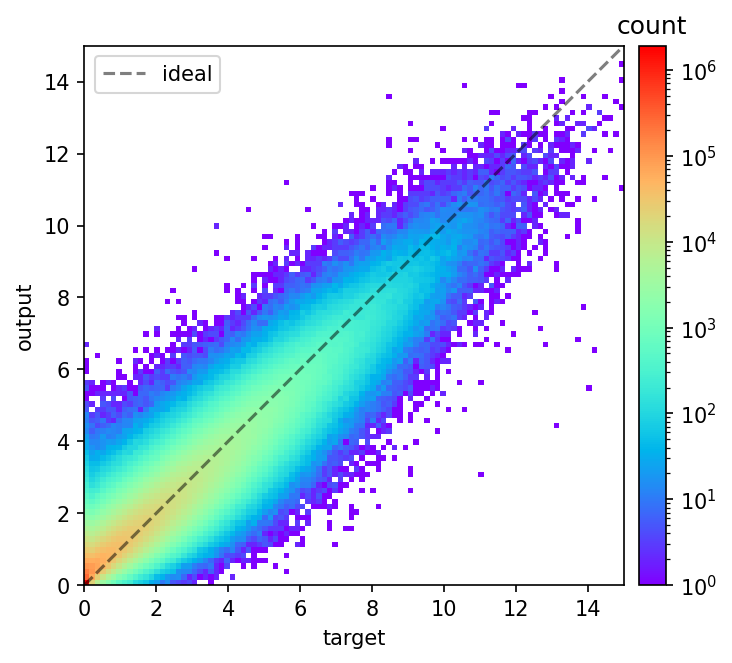

0.32003528243902013


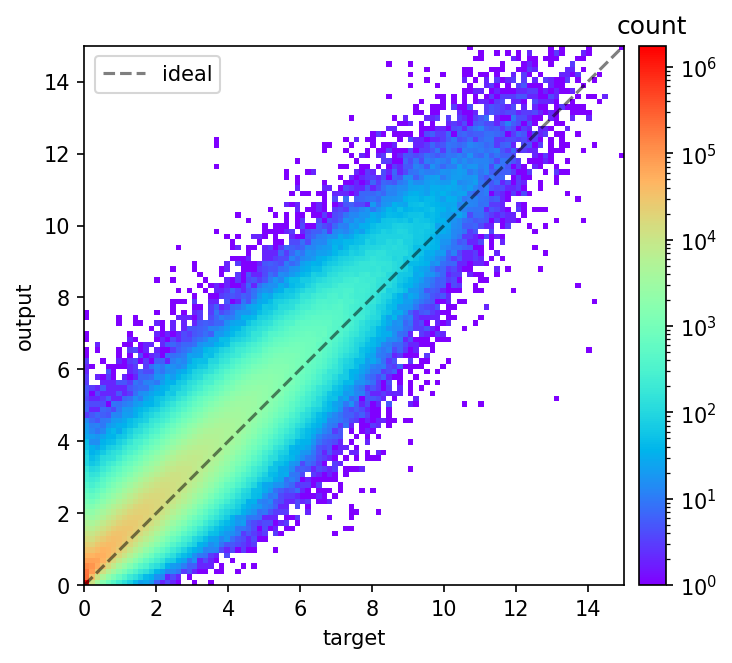

0.1806158329707571


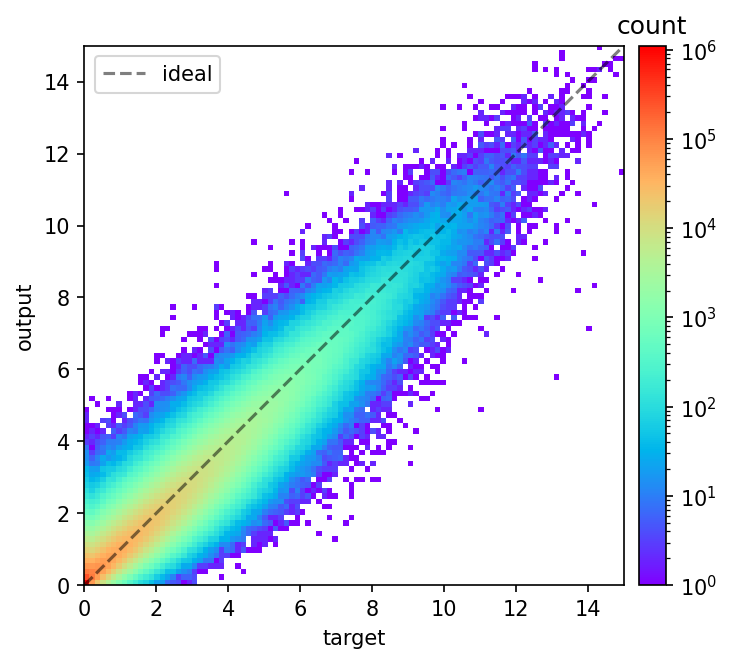

0.22729807923370954


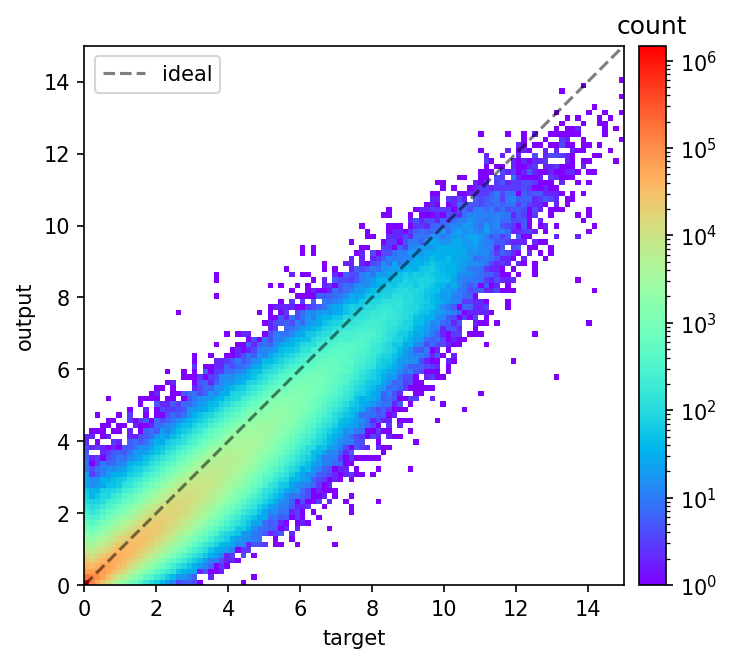

0.20908034006068132


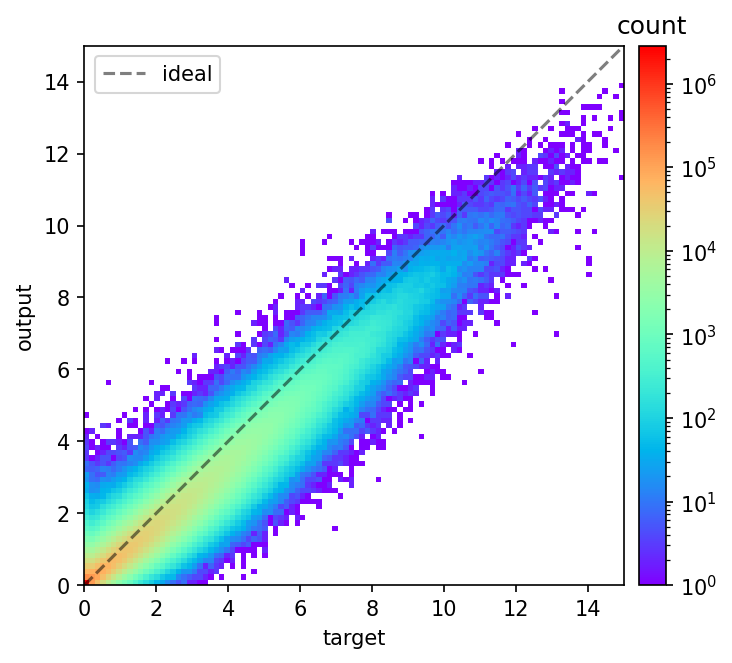

0.14476633427982824


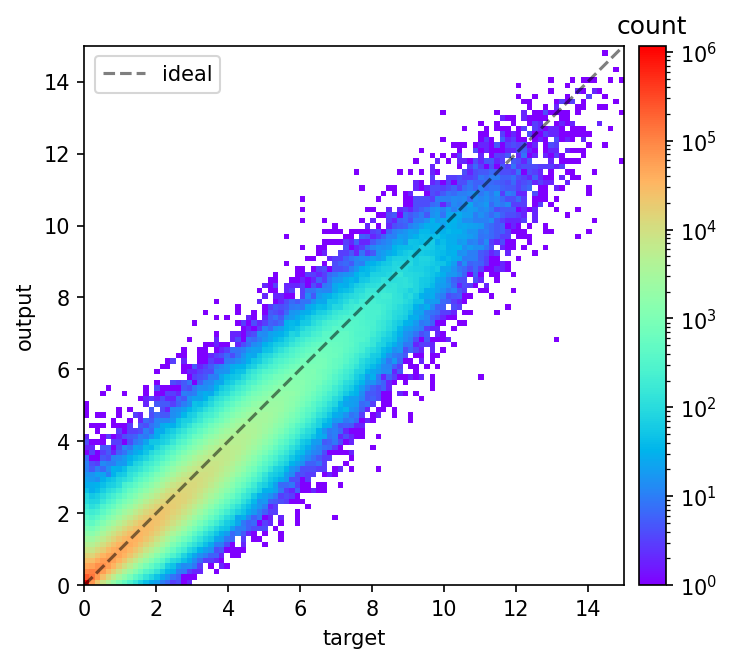

0.18176423711076578


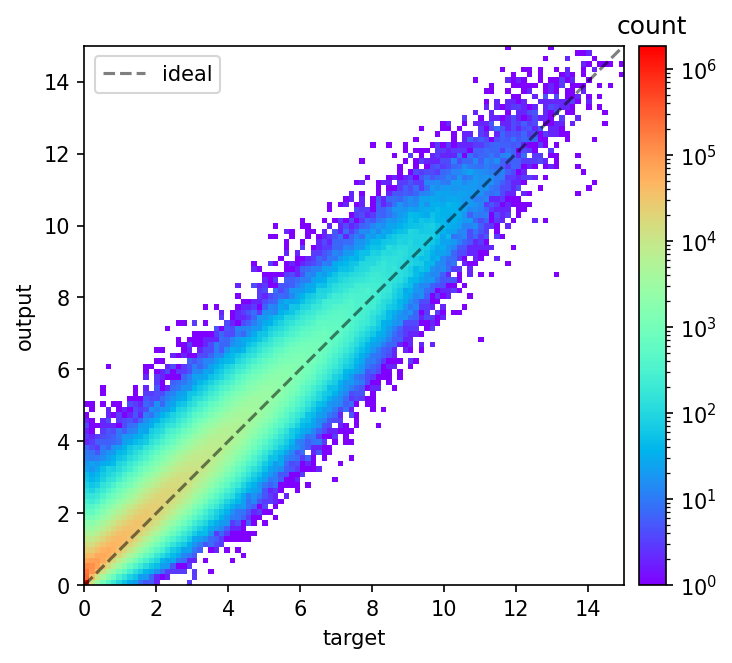

0.12086412266268612


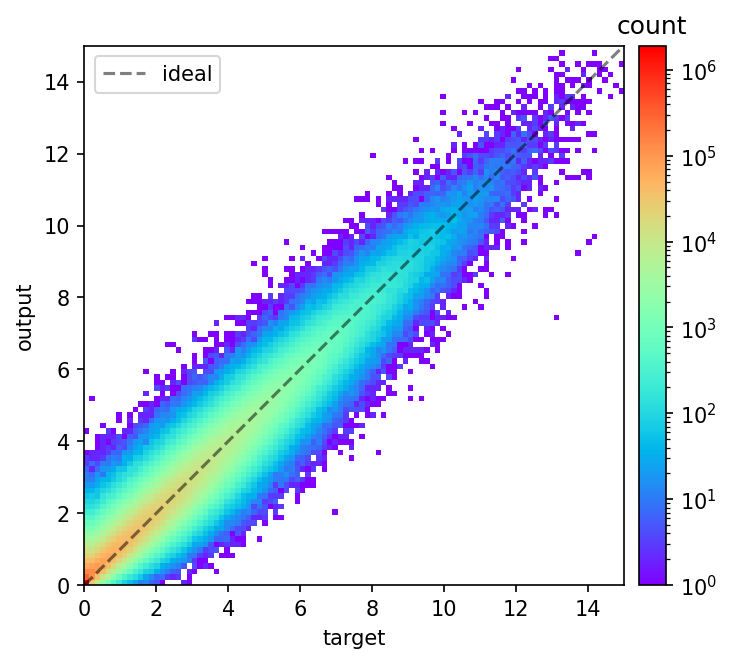

0.14302015434223647


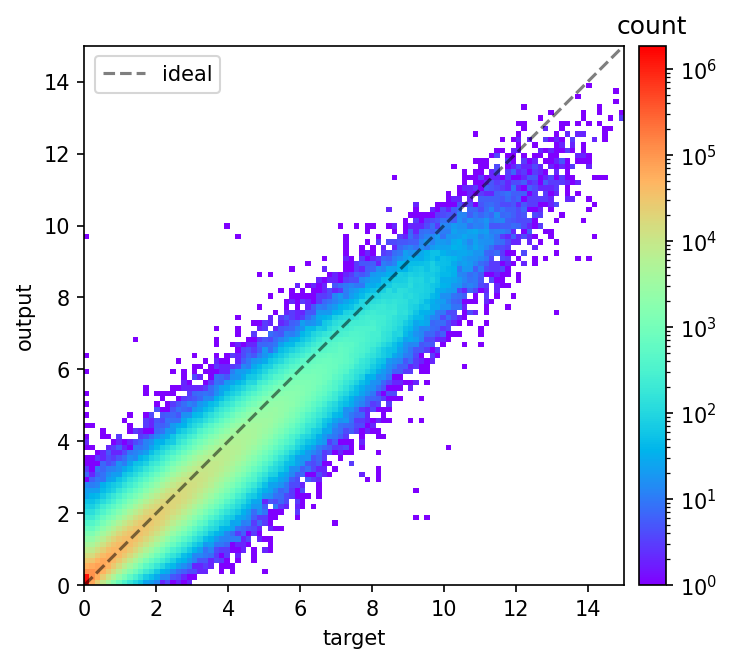

0.15854945328379777


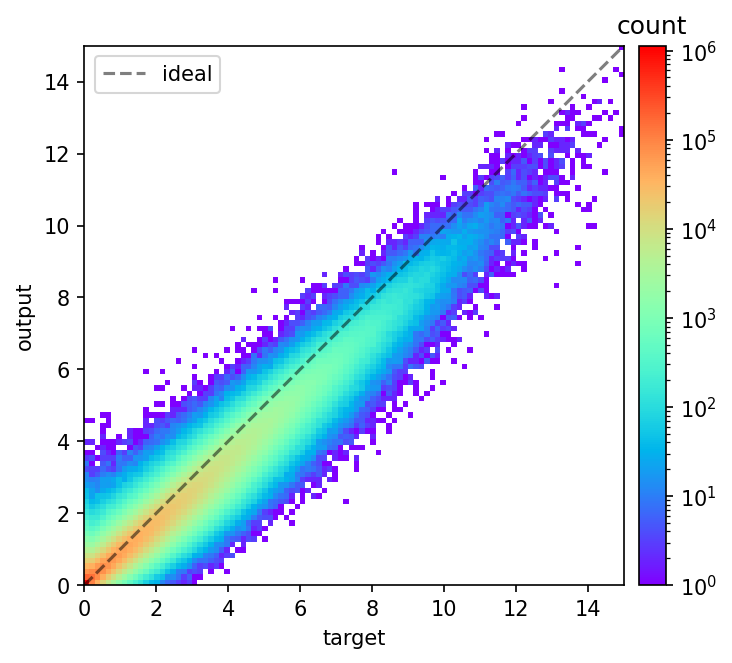

0.10250527348776925


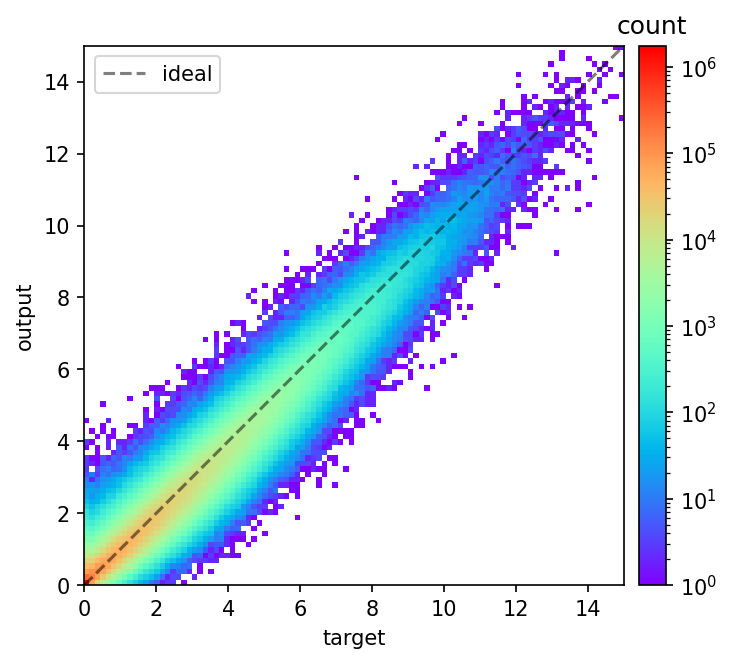

0.10507787389874992


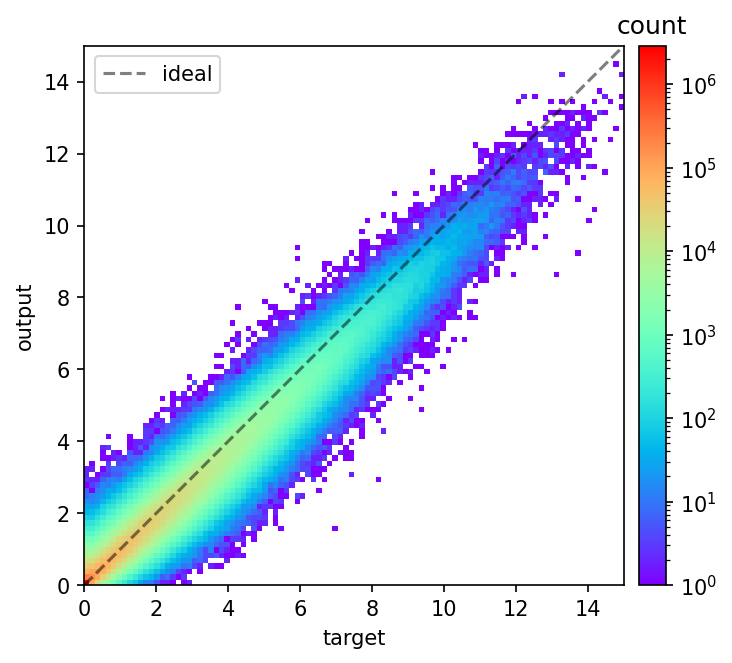

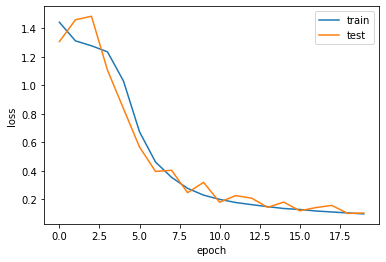

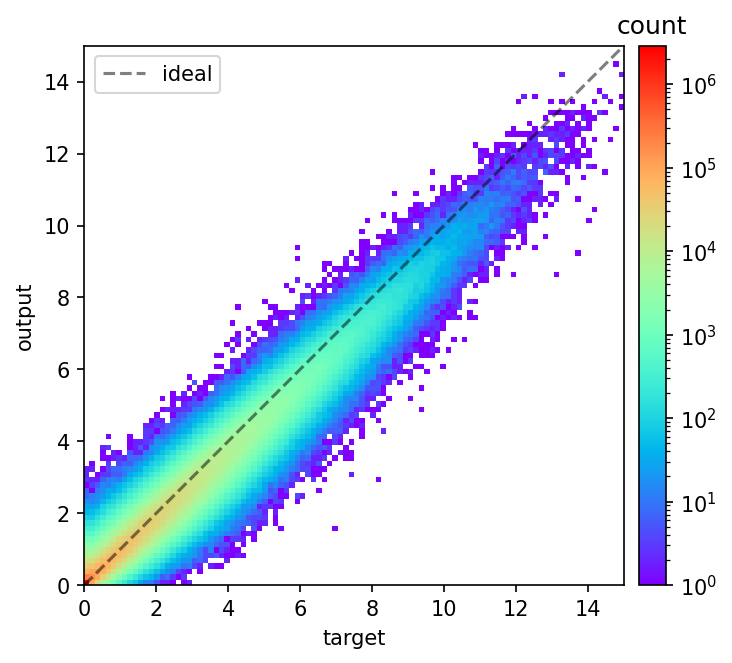

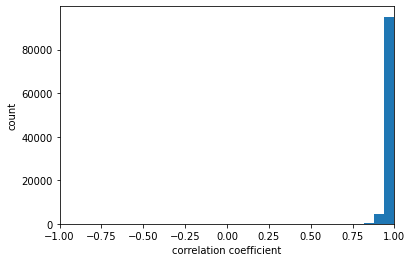

0.9760804921890158


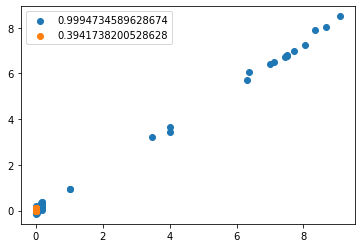

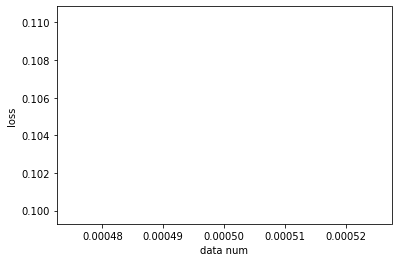

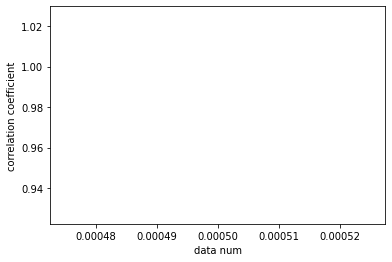

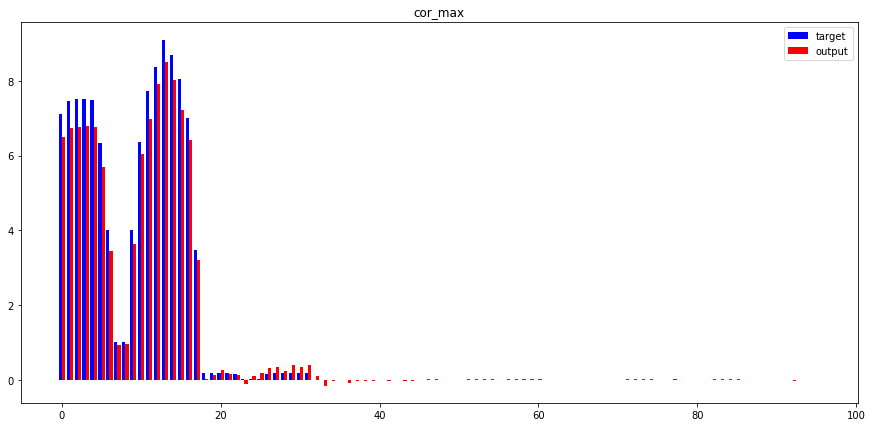

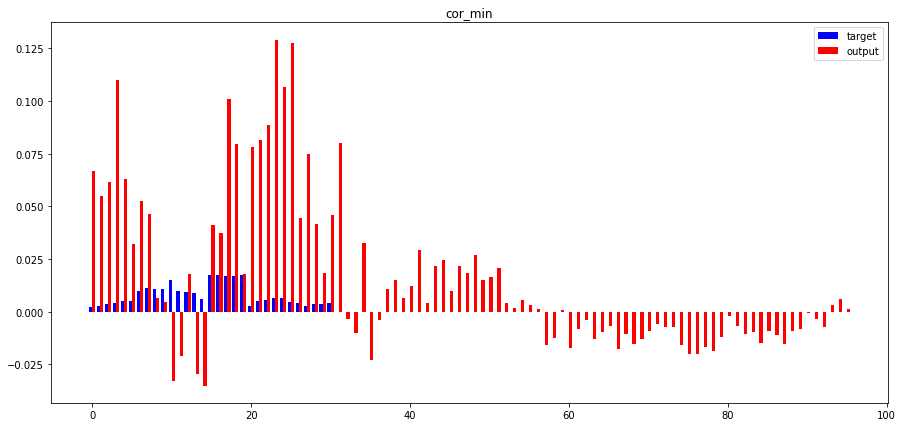

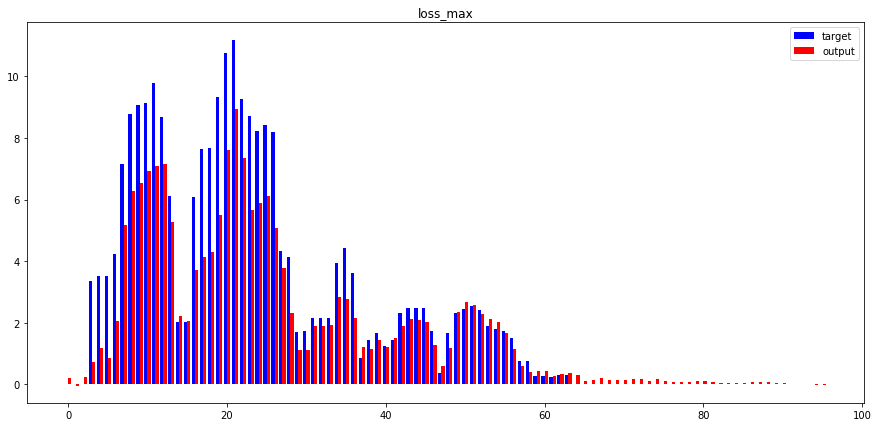

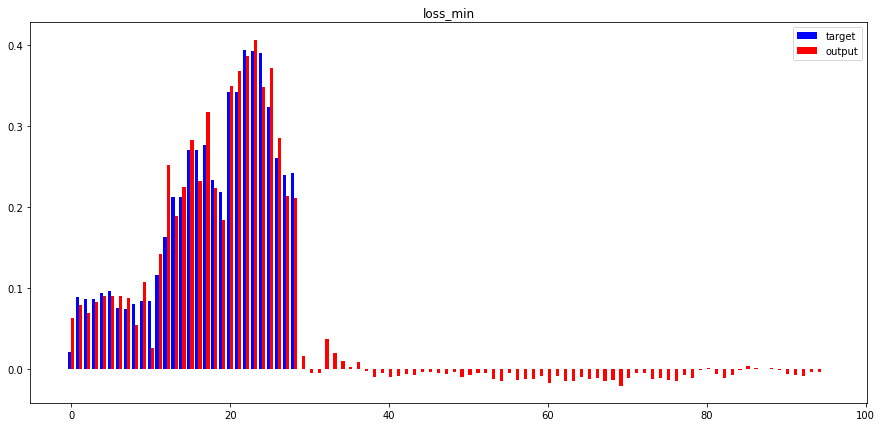

cor_max CAAAGUAACCAUGACUCUGGCAGUUGAUACUGCCCU
cor_min AAUUAAAUAUCACACGCCAACUACCACUACUCUAA
loss_max ACUGGUCGUGUGAUCCCAAUCGGAUUCUCGACCCACCCGGGGCCGGGCCAGAUGGCCUAGCAAAUCUU
loss_min GUUCCCGACAUCUCUGACCCCUUUAUAGUAUUA


In [11]:
datanumloss_list = []
datanumcor_list = []
listing = [5e-4]

for abc in listing:
  prm = abc

  train_dataset = Dataset(input_train, target_train)
  test_dataset = Dataset(input_test[0:100000], target_test[0:100000])
  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=True, num_workers=1)
  test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,shuffle=True, num_workers=1)

  '''
  class Net(nn.Module):
    def __init__(self, num_layer=64, num_filters=256, kernel_sizes=5):
        super(Net, self).__init__()
        self.activation = F.relu
        
        emb_dim=3
        self.embedding = nn.Embedding(5, emb_dim)
        
        #第一層
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=emb_dim, out_channels=num_filters, kernel_size=kernel_sizes, padding=kernel_sizes//2)])
        self.convs.append(nn.BatchNorm1d(num_filters))
        #第二層以降
        for i in range(1, num_layer):
            self.convs.append(nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_sizes, padding=kernel_sizes//2))
            self.convs.append(nn.BatchNorm1d(num_filters))
        #最終層
        self.convs.append(nn.Conv1d(in_channels=num_filters, out_channels=1, kernel_size=5))
        

    def forward(self, x):
        x = self.embedding(x.long())
        x = torch.transpose(x, 1, 2)
        for i, l in enumerate(self.convs):
            x = l(x)
            if(i%2==1):
                x = self.activation(x)    
        x = x.view(x.shape[0], -1)
        return x
  '''
  class Net(nn.Module):
    def __init__(self, num_layer=64, num_filters=128, kernel_sizes=5):
        super(Net, self).__init__()
        self.activation = F.relu
        self.channel = num_filters
        self.max_length = 100
        emb_dim=2
        self.embedding = nn.Embedding(5, emb_dim)
 
        #第一層
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=emb_dim, out_channels=num_filters, kernel_size=kernel_sizes, padding=kernel_sizes//2)])
        self.convs.append(nn.BatchNorm1d(num_filters))
        #第二層以降
        for i in range(1, num_layer):
            self.convs.append(nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_sizes, padding=kernel_sizes//2))
            self.convs.append(nn.BatchNorm1d(num_filters))
        #最終層
        #self.convs.append(nn.Conv1d(in_channels=num_filters, out_channels=1, kernel_size=5))
        self.fc = nn.Linear(self.max_length*num_filters, self.max_length-4)

    def forward(self, x):
        x = self.embedding(x.long())
        x = torch.transpose(x, 1, 2)
        for i, l in enumerate(self.convs):
            x = l(x)
            if(i%2==1):
                x = self.activation(x)
            
        x = x.view(-1, self.max_length*self.channel)
        x = self.fc(x)
        return x

    
  net = Net().cuda()
  optimizer = optim.Adam(net.parameters(), lr=prm, weight_decay=1e-6)
  #optimizer = optim.SGD(net.parameters(), lr=8e-3, weight_decay=8e-7, momentum=0.9)
  criterion = nn.MSELoss().cuda()
  epochs = 20

  print('nyaa', prm)

  train_loss_list = []
  val_loss_list = []
  tmp = 0

  for epoch in tqdm(range(epochs)):
      train_loss = 0
      val_loss = 0

      net.train()
      for data, target in train_dataloader:
          data, target = data.cuda(), target.cuda()
          optimizer.zero_grad()
          output = net(data)
          loss = criterion(output, target)
          train_loss += loss.item()
          loss.backward()
          optimizer.step()

      avg_train_loss = train_loss / len(train_dataloader)
      train_loss_list.append(avg_train_loss)
      #print('Epoch: {};  '.format(epoch))
      #print('train_loss: {:.3f}'.format(avg_train_loss))
      #print('learnig_rate: {}'.format(optimizer.param_groups[0]['lr']))

      #lr_scheduler.step()

      net.eval()
      data_all = []
      target_all = []
      output_all = []
      loss_list = []
      with torch.no_grad():
          for data, target in test_dataloader:
              data, target = data.cuda(), target.cuda()
              output = net(data)
              for i in range(len(target)):
                    data_all.append(data[i].cpu().numpy())
                    target_all.append(target[i].cpu().numpy())
                    output_all.append(output[i].cpu().numpy())
              loss = criterion(output, target)
              val_loss += loss.item()
              
          
          avg_val_loss = val_loss / len(test_dataloader)
          #if((abs(avg_val_loss-tmp)<1e-4) | (avg_val_loss<0.15)):
          if((avg_val_loss<0.10)):
              val_loss_list.append(avg_val_loss)
              break
          tmp = avg_val_loss
          val_loss_list.append(avg_val_loss)
      print(avg_val_loss)
      plot_result(np.array(target_all).reshape(-1), np.array(output_all).reshape(-1))
            
  torch.save(net.state_dict(), 'random_length100')

  plt.plot(range(epoch+1), train_loss_list, label='train')
  plt.plot(range(epoch+1), val_loss_list, label='test')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()



  plot_result(np.array(target_all).reshape(-1), np.array(output_all).reshape(-1))
  
  cor_list, loss_list = cal_indicators(target_all, output_all)


  plt.hist(cor_list)
  plt.xlim(-1, 1)
  plt.xlabel('correlation coefficient')
  plt.ylabel('count')
  plt.show()
  print(np.average(cor_list))

  plt.scatter(target_all[np.argmax(cor_list)], output_all[np.argmax(cor_list)], label=max(cor_list))
  plt.scatter(target_all[np.argmin(cor_list)], output_all[np.argmin(cor_list)], label=min(cor_list))
  plt.xlabel('target')
  plt.ylabel('output')
  plt.legend()
  plt.show()

  datanumloss_list.append(avg_val_loss)
  datanumcor_list.append(np.average(cor_list))
plt.plot(listing, datanumloss_list)
plt.xlabel('data num')
plt.ylabel('loss')
plt.show()

plt.plot(listing, datanumcor_list)
plt.xlabel('data num')
plt.ylabel('correlation coefficient')
plt.show()

visible_minmax(target_all, output_all, cor_list, loss_list)
show_base(data_all, cor_list, loss_list)

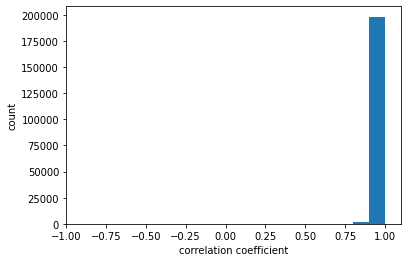

0.9760126309394077


In [17]:
'''
import cloudpickle

with open('cnn_only.pkl', 'wb') as f:
    cloudpickle.dump(net, f)
'''


In [20]:
input_val = pickle.load(open("../data/acc_len5_random100/input_test.pkl","rb"))
target_val = pickle.load(open("../data/acc_len5_random100/target_test.pkl","rb"))
print(input_val.shape)
val_dataset = Dataset(input_val, target_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64,shuffle=False, num_workers=1)

net.load_state_dict(torch.load("random_length100"))
net.eval()
data_all = []
target_all = []
output_all = []
val_loss = 0  
with torch.no_grad():
    start = time.time()
    for data, target in val_dataloader:
        data, target = data.cuda(), target.cuda()
        output = net(data)
        for i in range(len(target)):
            data_all.append(data[i].cpu().numpy())
            target_all.append(target[i].cpu().numpy())
            output_all.append(output[i].cpu().numpy())
        loss = criterion(output, target)
        val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    
    with open('accessibility_output.txt', 'w') as f:
        print(output, file=f)
    finish = time.time()
print('予測時間', (finish-start))

torch.Size([500000, 100])
予測時間 129.09564352035522


test_loss: 0.105


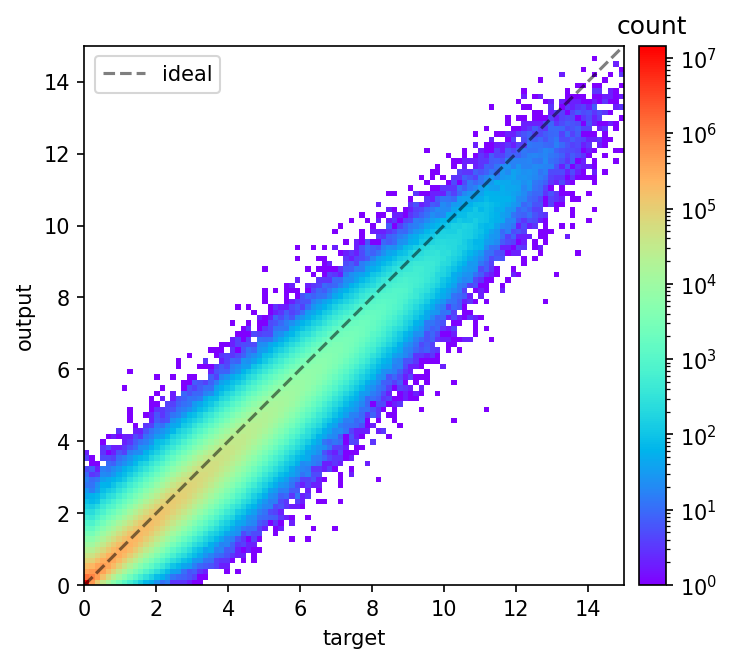

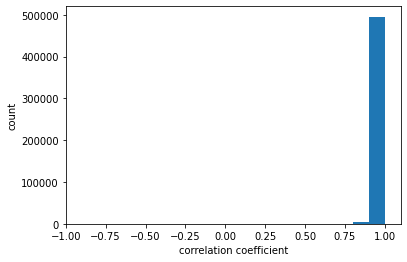

0.9760518790173695


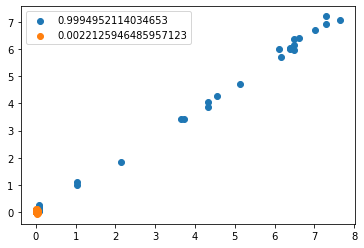

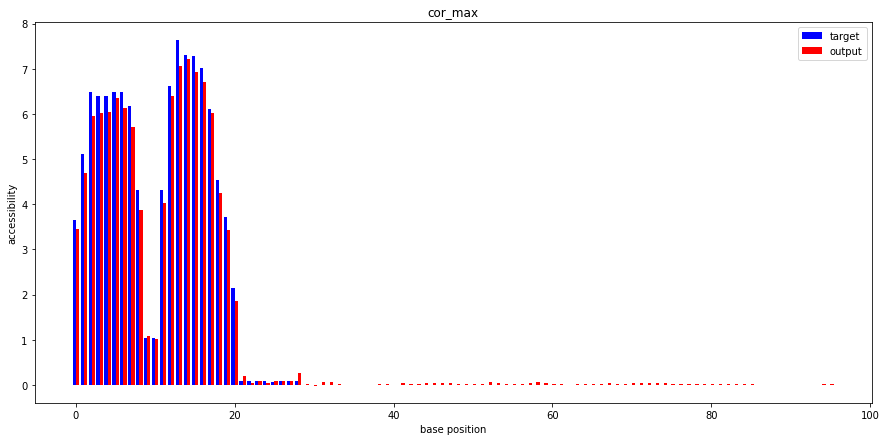

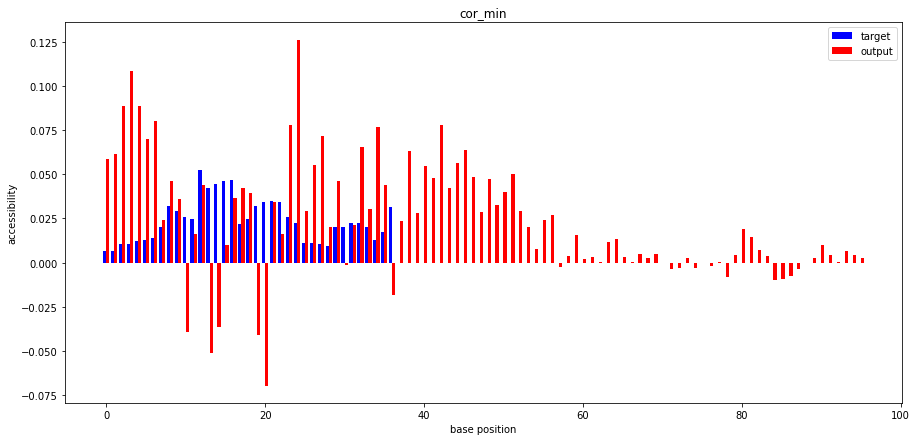

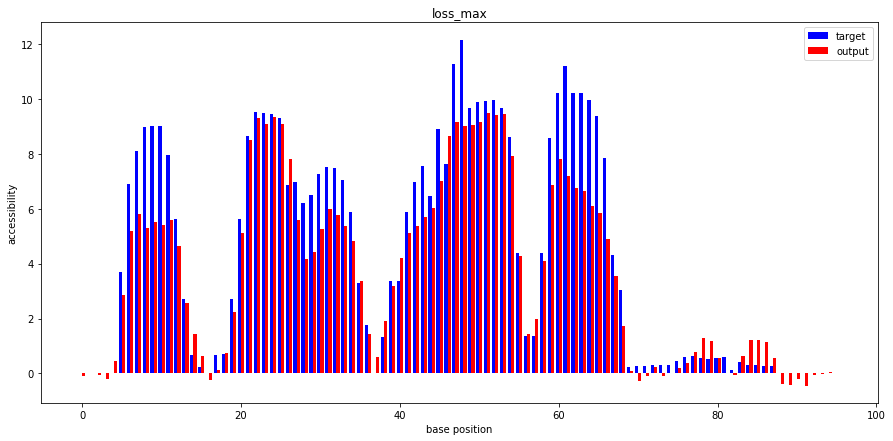

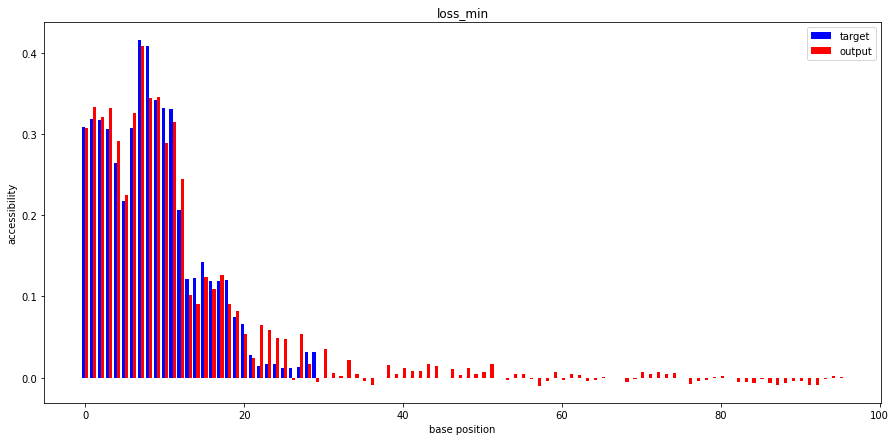

In [21]:
print('test_loss: {:.3f}'.format(avg_val_loss))

plot_result(np.array(target_all).reshape(-1), np.array(output_all).reshape(-1))

cor_list, loss_list = cal_indicators(target_all, output_all)

plt.hist(cor_list)
plt.xlim(-1, 1.1)
plt.xlabel('correlation coefficient')
plt.ylabel('count')
plt.show()
print(np.average(cor_list))

plt.scatter(target_all[np.argmax(cor_list)], output_all[np.argmax(cor_list)], label=max(cor_list))
plt.scatter(target_all[np.argmin(cor_list)], output_all[np.argmin(cor_list)], label=min(cor_list))
plt.legend()
plt.show()


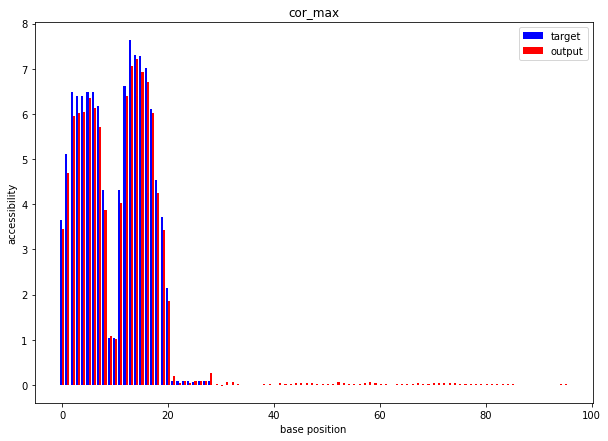

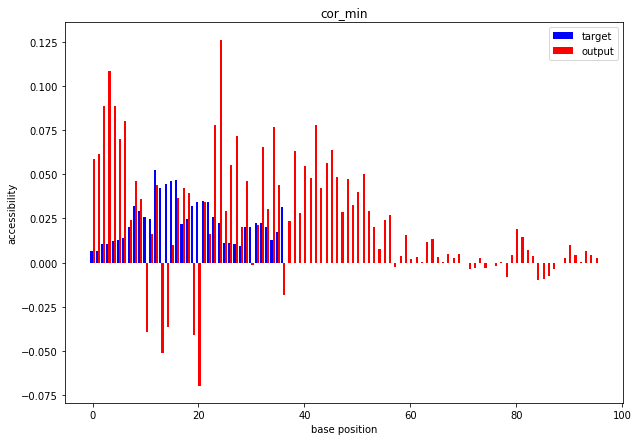

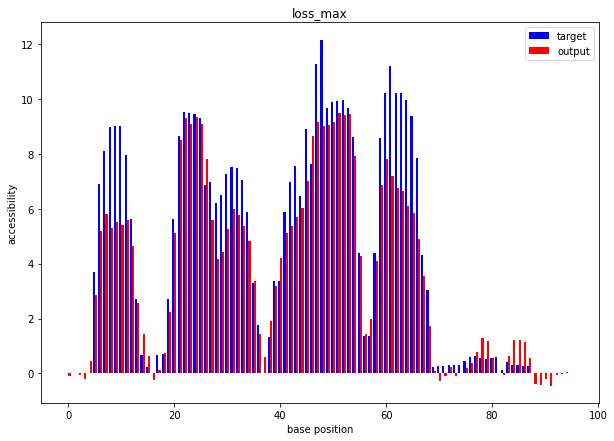

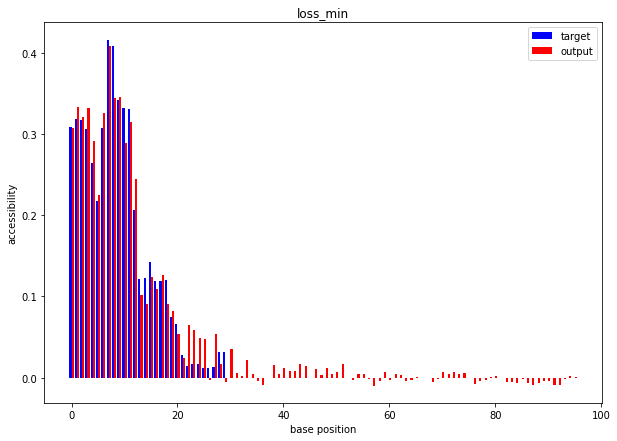

cor_max UAGGCCUCUUAUCACGAGUGGAAGCUCGUGCAA
cor_min GUCCAUACCUCCCAUCCACAACCUGCCCGCCUUACUUAUAA
loss_max AAAUCACUAGGAUAAGAUCGCUUCAGGGGCAGCGCUGCUCCUGGGAGAGGCAGCACCCUCCGUUGGGGCCAUGUUUUUGCCCCUCCCUUCAU
loss_min GAGCCCUAAAAAAUCCAAUCCUGAGUCUUUCGAG


In [33]:
visible_minmax(target_all, output_all, cor_list, loss_list)
show_base(data_all, cor_list, loss_list)

random= 192357


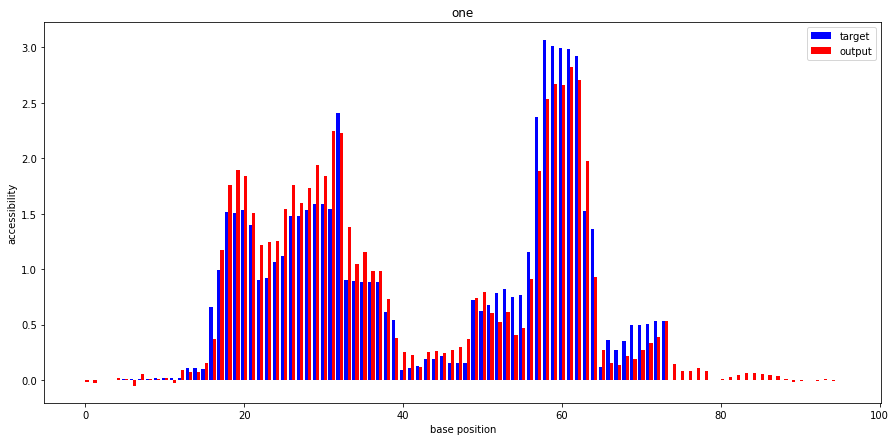

random= 464608


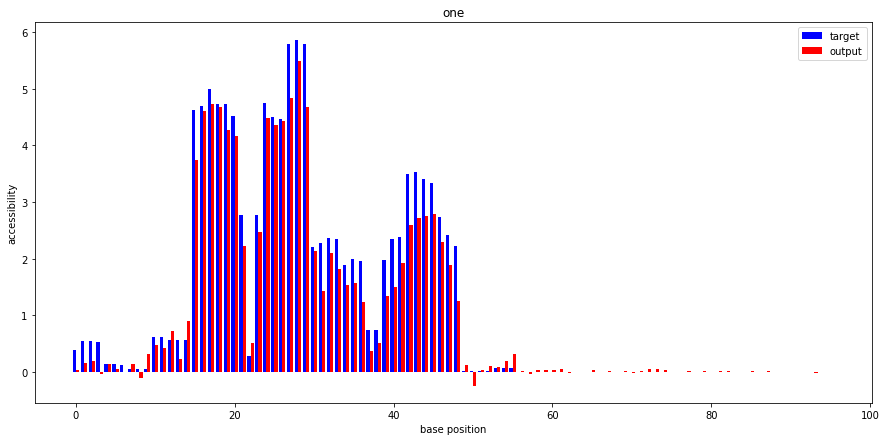

random= 298692


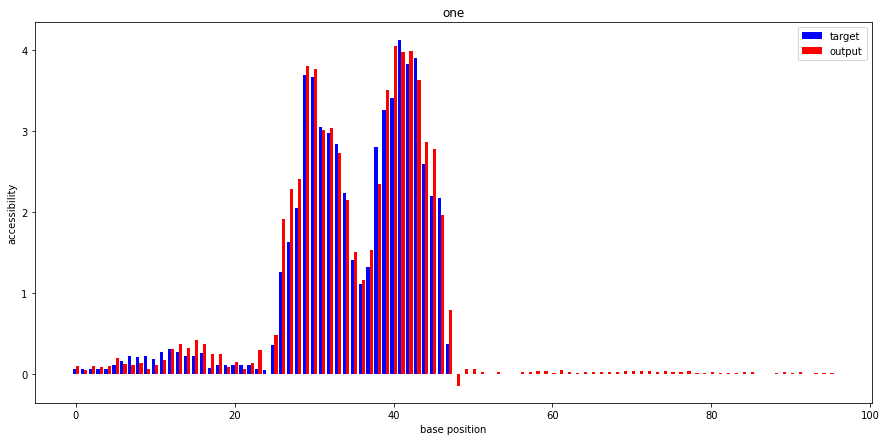

random= 149734


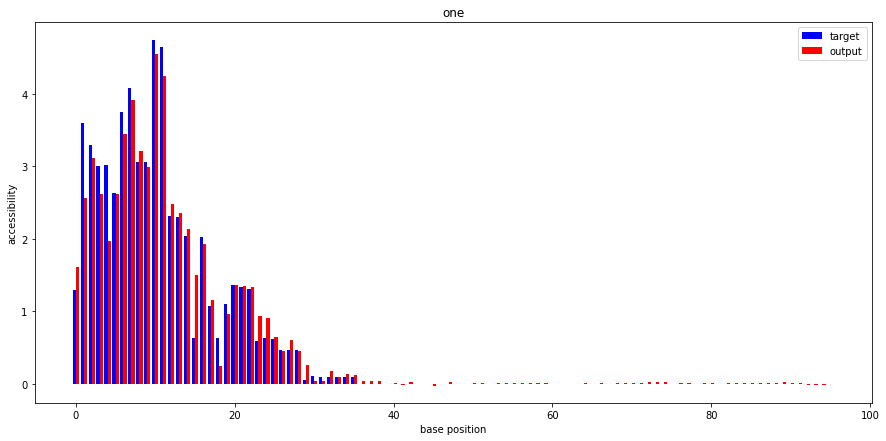

In [32]:
visible_one(target_all, output_all)
visible_one(target_all, output_all)
visible_one(target_all, output_all)
visible_one(target_all, output_all)

In [16]:
#メモリ確認
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #10M以上のみ表示
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                 cor_list|   1671800|
|                 data_all|   1671800|
|                loss_list|   1671800|
|               output_all|   1671800|
|               target_all|   1671800|
